# Cross Validation

Con el fin obtener un mejor performance del modelo se realiza una validación Cruzada, esto con el fin de identificar que modelos pueden llegar a tener un mejor desempeño.

Para esto se define una muestra base inicial, con el fin de que las validaciones puedan reproducibles con resultados iguales.

In [2]:
import warnings
warnings.simplefilter("ignore")

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score #Libreria utilizada para hacer la validación cruzada
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate #Esta libreria otorga mas información sobre el comportamiento del modelo
from sklearn.neighbors import KNeighborsRegressor #Modelo a probar con los datos
from sklearn.model_selection import validation_curve #Funcion para generar la curva de validación
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import learning_curve #Modelo para cronstruir la curva de aprendizaje

#### Se debe tener en cuenta que los datos utilizados en este script contienen las nuevas columnas obtenidas en la etapa de selection features. Adicionalmente se ha realizado una reducción en el volumen de datos esto debido a que en muchos casos se desconocia la cantidad de cines donde la pelicula se habia estrenado.

In [4]:
X = pd.read_csv(r'C:\Scripts\Proyectos\Predicción_de_ingresos_peliculas\Data\X_opening_p.csv')
y = X['worldwide_gross']
X = X.drop('worldwide_gross',axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1) #El parametro random_state define cual de los escenarios se va a llamar de forma igual siempre.

In [6]:
scores = cross_val_score(Lasso(),X,y,cv=5,scoring='r2') #En la configuración de la función se define la cantidad de veces que queremos dividir los datos así como la medida que se quiere estimar, en este caso r2.
scores

array([0.59316596, 0.68931527, 0.55383855, 0.18147236, 0.23040894])

In [7]:
scores.mean()

0.44964021745791716

De esto se obtiene un score promedio de 0.44, de esto se procede a comparar con el error generado por el metodo tradicional.

In [8]:
Lasso().fit(X_train,y_train).score(X_test,y_test)

0.7926190294963362

De esto se establece que el Score robusto para el modelo sera de 0.4496 y el score convencional sera de 0.7926

# Model Selection

En esta etapa del modelo se evaluara si el modelo de Lasso que se trato de aplicar inicialmente es insuficiente o esta generando algún problema de overfiting o underfiting que este interviniendo en la performance del modelo.

In [9]:
results = cross_validate(Lasso(),X,y,return_train_score=True,cv=5)
results

{'fit_time': array([0.00999045, 0.02797914, 0.02998257, 0.02698231, 0.01898909]),
 'score_time': array([0.0039978 , 0.00399947, 0.00299644, 0.00299883, 0.00199795]),
 'test_score': array([0.59316596, 0.68931527, 0.55383855, 0.18147236, 0.23040894]),
 'train_score': array([0.68988012, 0.77004932, 0.76604995, 0.76123379, 0.75837599])}

In [15]:
test_scores = results['test_score']
train_scores = results['train_score']
print(np.mean(train_scores))
print(np.mean(test_scores))

0.7491178363039036
0.44964021745791716


Con esta validación se determina que hay una diferencia importante entre los scores de entrenamiento y prueba, lo que indica una varianza alta. Adicionalmente, se detecta que el score en los datos de prueba deberia ser más alto a pesar de que un 0.74 no es malo, de esto se determina que posiblemente el modelo presente un sesgo lo que se traduce a que el modelo no se esta encajando de la forma deseada con los datos.

Debido a esto se procede a probar con un modelo que se cree que pueda llegar a tener un mejor performance con los datos. El modelo seleccionado es **KNeighbors**. Adicionalmente se escoje este modelo con el fin de poder ver la curva de validación y una de aprendizaje.

In [17]:
cross_validate(KNeighborsRegressor(), X, y, cv=5) #En este caso no se determina el número de vecinos en 5 de forma predeterminada.

{'fit_time': array([0.01698709, 0.00699401, 0.00699472, 0.00899482, 0.00799513]),
 'score_time': array([0.00799727, 0.00599647, 0.00699496, 0.00799465, 0.00999427]),
 'test_score': array([0.3647382 , 0.59274527, 0.21545625, 0.15143495, 0.25635077])}

In [19]:
cross_validate(KNeighborsRegressor(n_neighbors=10), X, y, cv=5) #En este caso no se determina el número de vecinos en 10 para evaluar el performance del modelo.

{'fit_time': array([0.01099157, 0.01598859, 0.01299024, 0.01098967, 0.01898813]),
 'score_time': array([0.0089972 , 0.01299429, 0.0099988 , 0.00999451, 0.01599288]),
 'test_score': array([0.23553954, 0.61921355, 0.24881301, 0.1209604 , 0.2466995 ])}

Debido a los datos obtenidos se estima la curva de validación

In [23]:
n = np.arange(2,50,2) #Este n hace referencia a la cantidad de vecinos que se van a obtener.
train_scores,test_scores = validation_curve(KNeighborsRegressor(),X,y,param_name='n_neighbors',param_range=n,cv=5) #Es importante saber que se debe establecer el parametro que se va a variar en este caso n_neigbors

In [22]:
np.mean(train_scores,axis=1)

array([0.86831591, 0.79120817, 0.7593398 , 0.7498298 , 0.74238245,
       0.73284018, 0.72586058, 0.71779833, 0.71281982, 0.70976325,
       0.70723469, 0.70502429, 0.70174649, 0.69741543, 0.69379214,
       0.69163113, 0.68955146, 0.6862285 , 0.68321376, 0.68018032,
       0.67885534, 0.67522056, 0.67135123, 0.66953759])

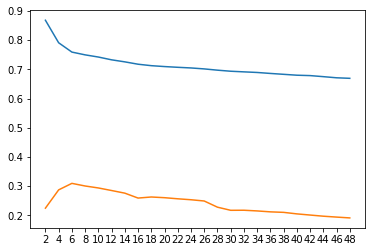

In [25]:
plt.plot(np.mean(train_scores,axis=1))
plt.plot(np.mean(test_scores,axis=1))
plt.xticks(np.arange(24),n);

De las curvas de validación se concluye que se sigue presentando un sesgo importante a pesar del cambio del modelo, por lo cual se requiere hacer algunas optimizaciones adicionales.

**Nota:** Lo que se busca es obtener el maximo valor de la curva de test, esto con el fin de saber cual es el mejor parametro, sin embargo para este caso no fue optimo.

De forma complementaria se valida la curva de aprendizaje para validar si la cantidad de datos es suficiente o se deben agregar mas datos al modelo.

In [29]:
lcurve = learning_curve(KNeighborsRegressor(n_neighbors=6),X,y,cv=5) #A la función se le entregan los n así como la cantidad de divisiones.
#El 6 se escoje de los resultados de la curva de validación

samples,train,test = lcurve[0], lcurve[1],lcurve[2]

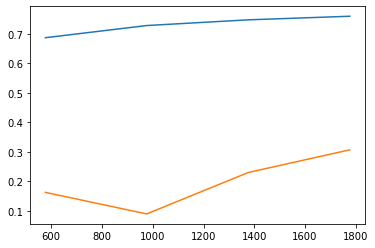

In [28]:
plt.plot(samples[1:],np.mean(train,axis=1)[1:])
plt.plot(samples[1:],np.mean(test,axis=1)[1:])

De esto se determina que si bien el modelo esta aprendiendo adecuadamente con los datos entregados, la cantidad de estos hasta el momento es insuficiente para que el modelo tenga el aprendizaje deseado.